# MnistNet
*Inception network for MNIST data set implemented with keras  
Author: Ariel Lev   
Date: 18.01.2018*

Using TensorFlow backend.


('x_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')
channel=channels_last


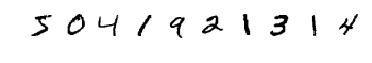

In [1]:
%run 'commons.ipynb'

from keras.datasets import mnist

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# display image
def display(images):
    i=1
    for img in images:
        plt.subplot(1,len(images),i)
        plt.axis('off')
        plt.imshow(img, cmap=cm.binary)
        i=i+1

# output images
display(x_train[0:10])

print("channel=%s" % K.image_data_format())

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

# vector representation of class lables. one hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [2]:
cxt = Context('mnist-net', 1)
tensor_board = keras.callbacks.TensorBoard(log_dir=cxt.log_path, histogram_freq=1, batch_size=32, write_graph=True)

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensor_board])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 379s 6ms/step - loss: 0.2603 - acc: 0.9193 - val_loss: 0.0529 - val_acc: 0.9825
('Test loss:', 0.052910863296920435)
('Test accuracy:', 0.98250000000000004)


In [4]:
# save as keras model
model.save(cxt.keras_path)

# export to tenstor-serving
builder = tf.saved_model.builder.SavedModelBuilder(cxt.model_path)
signature = signature(model.input, model.output)
with K.get_session() as sess:
    builder.add_meta_graph_and_variables(sess=sess,
                                         tags=[tf.saved_model.tag_constants.SERVING],
                                         signature_def_map=signature_def_map(signature))
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/ml/models/mnist-net/1/saved_model.pb
